In [ ]:
# Math
import numpy as np
from numpy.polynomial import chebyshev
import sklearn.preprocessing as pp
import sklearn.linear_model as lm
import scipy as sp

# Plotting
import matplotlib.pyplot as plt
from corner import corner

# Astropy
from astropy.io import fits
from astropy.table import Table

# File manipulation
import wget
import urllib.request
from bs4 import BeautifulSoup
import os
import requests
import re
from threading import Thread
from glob import glob
from tqdm.auto import tqdm
import pandas as pd

## Q1

In [ ]:
def is_fits(s):
    fitsPattern = r"apStar-.*\.fits\b"
    matches = re.match(fitsPattern, s)
    return matches

In [ ]:
def clean_fits_directory(fields):
    fitsDir = './fits_files'
    for field in fields:
        fieldDir = os.path.join(fitsDir, field)
        fitsFnames = glob(os.path.join(fieldDir, '*'))
        for fname in fitsFnames:
            temp = os.path.split(fname)[-1]
            if not is_fits(temp):
                os.remove(fname)
                print(f"{temp} has been removed bc it is not a .fits file")

def download_fits(fields):
    apogeeUrl = "https://data.sdss.org/sas/dr16/apogee/spectro/redux/r12/stars/apo25m"
    fitsDir = './fits_files'
    
    for field in fields:
        targetSpectraUrl = os.path.join(apogeeUrl, field)
        targetSpectraOutDir = os.path.join(fitsDir, field)
        if not os.path.exists(targetSpectraOutDir):
            os.makedirs(targetSpectraOutDir)
        
        soup = BeautifulSoup(requests.get(targetSpectraUrl).text)
        for a in soup.find_all('a'):
            link = a['href']
            targetSpectraFname = os.path.join(targetSpectraOutDir, link)
            if os.path.exists(targetSpectraFname):
                continue
            if (is_fits(link)):
                targetSpectraLink = os.path.join(targetSpectraUrl, link)
                try:
                    wget.download(targetSpectraLink, out = targetSpectraFname)
                except:
                    print(f"Something went wrong when downloading '{targetSpectraLink}'")
        print(f"Finished downloading {field} spectra!")
    print("Finished!")

def download_fits_threaded(fields):
    download_thread = Thread(target=download_fits, name="Fits Downloader", args=[fields])
    download_thread.start()
    return download_thread

def count_fits_files():
    fitsDir = './fits_files'
    print(f"{'Dirname':<20} {'Count'}")
    print("-"*(len('Dirname')+20))
    total = 0
    for r, d, files in os.walk(fitsDir):
        root = os.path.split(r)[-1]
        if not root == 'fits_files':
            print(f"{root:<20} {len(files)}")
            total += len(files)
    print(f"{'Total':<20} {total}")

In [ ]:
spectraFields = ["M15", "N6791",  "K2_C4_168-21", "060+00"]

In [ ]:
# DO NOT RUN THIS AGAIN LMAO
# download_thread = download_fits_threaded(spectraFields)

In [ ]:
# Uncomment and run this if download fails
# clean_fits_directory(spectraFields)

In [ ]:
# if (download_thread.is_alive()):
#     print("Download is still running...")
count_fits_files()

In [ ]:
def get_fits_fname_by_idx(field, idx):
    fitsDir = './fits_files'
    fieldDir = os.path.join(fitsDir, field)
    fullFname = glob(os.path.join(fieldDir, '*'))[idx]
    return os.path.join(field, os.path.split(fullFname)[-1])

In [ ]:
wl_start = 4.179
wl_delta = 6e-06
wl_count = 8575
wavelengths = np.logspace(wl_start, wl_start+wl_delta*wl_count, wl_count, base=10)

def get_fits_flux(fitsFname):
    fitsDir = './fits_files'
    fitsFname = os.path.join(fitsDir, fitsFname)
    with fits.open(fitsFname) as hdul:
        objID = hdul[0].header['OBJID']
        hduFlux = hdul[1]
        hduFluxErr = hdul[2]
        hduMask = hdul[3]
        
        flux = np.array(hduFlux.data.reshape(-1, wl_count)[0])
        fluxErr = np.array(hduFluxErr.data.reshape(-1, wl_count)[0])
        
        nullMask = (flux == 0)
        binaryMask = (hduMask.data[0] & 0b100001111111) != 0
        
        flux[nullMask] = np.nan
        fluxErr[nullMask] = np.nan
        fluxErr[binaryMask] *= 10
        
        return objID, flux, fluxErr

In [ ]:
fitsFname = get_fits_fname_by_idx(spectraFields[0], 0)
objID, flux, fluxErr = get_fits_flux(fitsFname)
plt.figure(figsize = (10,6))
plt.title(f"Spectrum of {objID}")
plt.plot(wavelengths, flux)
plt.ylim(plt.ylim())

plt.fill_between(wavelengths, flux-fluxErr, flux+fluxErr, alpha=0.2)
plt.show()

## Q2/Q3

In [ ]:
def load_all_stars(fields):
    fitsDir = './fits_files'
    allStarFname = 'allStarLite-r12-l33.fits'
    allStarPath = os.path.join(fitsDir, allStarFname)
    
    mainCols = [
        'LOGG',
        'TEFF',
        'M_H',
        'MG_FE',
        'SI_FE'
    ]
    metaCols = [
        'APOGEE_ID',
        'FIELD',
        'SNR',
        'ASPCAPFLAGS'
    ]
    
    errCols = [col + '_ERR' for col in mainCols]
    
    allStars = Table.read(allStarPath)
    allStars = allStars[np.isin(allStars['FIELD'].astype(str), fields)]
    allStars = allStars[metaCols + mainCols + errCols]
    
    snrMask = (allStars['SNR'] >= 50.0)
    loggMask = (allStars['LOGG'] <= 4.0)
    teffMask = (allStars['TEFF'] <= 5700.0)
    m_hMask = (allStars['M_H'] >= -1.0)
    
    errMask = np.ones(len(allStars), dtype=bool)
    for errField in errCols:
        errMask = errMask&(allStars[errField] >= 0.0)
    
    allStars = allStars[snrMask & loggMask & teffMask & m_hMask & errMask]
    allStars['index'] = np.arange(len(allStars))
    
    return allStars

In [ ]:
mainCols = [
        'LOGG',
        'TEFF',
        'M_H',
        'MG_FE',
        'SI_FE'
    ]
allStars = load_all_stars(spectraFields)

In [ ]:
corner(allStars[mainCols].to_pandas())
pass

## Q4

In [ ]:
def get_is_continuum(wavelengths):
    with np.load('continuum_pixels_apogee.npz') as npz:
        cpaWavelengths = npz['wavelength']
        cpaIsContinuum = npz['is_continuum']
    wavelengthsIsContinuum = (0.5 < np.around(np.interp(wavelengths, cpaWavelengths, cpaIsContinuum)))
    return wavelengthsIsContinuum

cpaChips = np.array([
    [ 15170.8, 15785.0 ],
    [ 15904.7, 16395.7 ],
    [ 16503.3, 16930.5 ]
])

In [ ]:
def pseudo_normalize(wavelengths, flux, fluxErr, deg):
    
    wavelengthsIsContinuum = get_is_continuum(wavelengths)
    isContinuumMask = wavelengthsIsContinuum & np.isfinite(flux)
    
    pseudoFlux = np.full(flux.shape, np.nan)
    
    for lo, hi in cpaChips:
        rangeMask = (wavelengths >= lo) & (wavelengths <= hi)
        mask = isContinuumMask & rangeMask
        
        chebCoeff = chebyshev.chebfit(wavelengths[mask], flux[mask], deg=deg, w=1/np.sqrt(fluxErr[mask]))
        pseudoFlux[rangeMask] = chebyshev.chebval(wavelengths[rangeMask], chebCoeff)
    
    fluxNorm = flux/pseudoFlux
    fluxErrNorm = fluxErr/pseudoFlux
    
    return fluxNorm, fluxErrNorm, pseudoFlux

In [69]:
def get_star_by_id(apogeeID):
#     allStars = load_all_stars(spectraFields)
    return allStars[allStars['APOGEE_ID'] == apogeeID]

def get_fits_by_id(apogeeID):
    fitsDir = './fits_files'
    for r, d, files in os.walk(fitsDir):
        for file in files:
            if apogeeID in file:
                field = os.path.split(r)[-1]
                print(field)
                return get_fits_flux(os.path.join(field, file))
    

In [ ]:
def plot_pseudo_normalized(apogeeID, deg=5):
    a, flux, fluxErr = get_fits_by_id(apogeeID)
    
    fluxNorm, fluxErrNorm, pseudoFlux = pseudo_normalize(wavelengths, flux, fluxErr, deg)
    
    fig, (ax1,ax2) = plt.subplots(2,1, figsize=(16,8))
    fig.suptitle(apogeeID)
    ax1.set(title='Spectrum', ylabel='Flux')
    ax1.plot(wavelengths, flux, lw=0.5, label='Spectrum')
    ax1.set_ylim(ax1.get_ylim())
    ax1.plot(wavelengths, pseudoFlux, label='Pseudo Continuum')
    ax1.fill_between(wavelengths, flux-fluxErr, flux+fluxErr, alpha=0.15)
    ax1.legend()
    
    ax2.plot(wavelengths, fluxNorm, lw=0.5)
    ax2.axhline(1, 0, 1, c='k', lw=1)
    ax2.set_ylim(ax2.get_ylim())
    ax2.fill_between(wavelengths, fluxNorm-fluxErrNorm, fluxNorm+fluxErrNorm, alpha=0.15)
    ax2.set(xlabel='Wavelength (Ang)', ylabel='NormalizedFlux', title="Pseudo-Normalized Spectrum")
    
    plt.show()

In [ ]:
apogeeID = '2M19395986+2341280'
plot_pseudo_normalized(apogeeID)

In [ ]:
allSpectraFname = 'allSpectra.npz'
if os.path.exists(allSpectraFname):
    print(f"Loading spectra from {allSpectraFname}")
    with np.load(allSpectraFname) as allSpectraNPZ:
        spectraFluxNorm = allSpectraNPZ['spectraFluxNorm']
        spectraFluxErrNorm = allSpectraNPZ['spectraFluxErrNorm']
        spectraPseudoNorm = allSpectraNPZ['spectraPseudoNorm']
else:
    spectraFluxNorm = np.empty((len(allStars), wl_count))
    spectraFluxErrNorm = np.empty(spectraFluxNorm.shape)
    spectraPseudoNorm = np.empty(spectraFluxNorm.shape)
    
    for i, star in enumerate(allStars):
        apogeeID = star['APOGEE_ID']
        a, flux, fluxErr = get_fits_by_id(apogeeID)
        spectraFluxNorm[i], spectraFluxErrNorm[i], spectraPseudoNorm[i] = pseudo_normalize(wavelengths, flux,fluxErr,deg=5)
        
    np.savez_compressed(allSpectraFname, spectraFluxNorm = spectraFluxNorm, spectraFluxErrNorm = spectraFluxErrNorm, spectraPseudoNorm=spectraPseudoNorm)
        

In [ ]:
spectraFluxNorm.shape

## Q5

In [ ]:
np.random.seed(283576)
idxs = np.arange(len(allStars))
np.random.shuffle(idxs)

middle = len(allStars)//2
trainIdxs = idxs[:middle]
valIdxs = idxs[middle:]

trainStars = allStars[trainIdxs]
trainFluxNorm = spectraFluxNorm[trainIdxs]
trainFluxErrNorm = spectraFluxErrNorm[trainIdxs]
trainPseudoNorm = spectraPseudoNorm[trainIdxs]

valStars = allStars[valIdxs]
valFluxNorm = spectraFluxNorm[valIdxs]
valFluxErrNorm = spectraFluxErrNorm[valIdxs]
valPseudoNorm = spectraPseudoNorm[valIdxs]

In [ ]:
49 in trainIdxs

## Q6

In [ ]:
normalizer = pp.StandardScaler().fit(trainStars[mainCols].to_pandas())
polynomializer = pp.PolynomialFeatures(include_bias = True, degree = 2)

def transform_features(features):
    features = features[mainCols]
    if not isinstance(features, pd.DataFrame):
        features = features.to_pandas()
    features = normalizer.transform(features)
    features = polynomializer.fit_transform(features)
    return features

In [ ]:
def log_prob(flux, fluxErr, fluxHat):
    sigmas = np.logspace(-4, 0, num = 50, base = 10)
    errMask = np.isfinite(fluxErr)
    r = (flux[errMask] - fluxHat[errMask])[:,None]
    outerSum = np.add.outer(fluxErr[errMask]**2, sigmas**2)
    prob = np.log(outerSum).sum(axis=0) + (r**2/outerSum).sum(axis=0)
    return sigmas[np.argmax(-prob)]
    
def fit_model(features, flux, fluxErr):
    thetas = np.full((wl_count, features.shape[1]), np.nan)
    sigmas = np.full(wl_count, np.nan)
    
    model = lm.LinearRegression(fit_intercept = False)
    
    for n in tqdm(range(wl_count)):
        pixelFlux = np.nan_to_num(flux[:,n], nan=0.0, copy=True)
        pixelFluxErr = np.nan_to_num(fluxErr[:,n], nan=np.inf, copy=True)
#         print(pixelFlux)
#         print(pixelFluxErr)
        model.fit(features, pixelFlux, sample_weight = 1/np.square(pixelFluxErr))
        thetas[n] = model.coef_
#         print(thetas)
        pixelFluxHat = model.predict(features)
        sigmas[n] = log_prob(pixelFlux, pixelFluxErr, pixelFluxHat)
#         print(sigmas)
#         break
        
    return thetas, sigmas

In [ ]:
trainFeatures = transform_features(trainStars)
thetas,sigmas = fit_model(trainFeatures, trainFluxNorm, trainFluxErrNorm)

In [ ]:
thetas.shape

In [ ]:
plt.figure(figsize=(16,8))
for i in range(thetas.shape[1]):
    plt.plot(thetas[:,i])
plt.show()

In [ ]:
def predict_spectra(spectra):
    features = transform_features(spectra)
    return features @ thetas.T, sigmas

## Q7

In [ ]:
def plot_fit(apogeeID):
    spectra = get_star_by_id(apogeeID)
    predFlux, predFluxErr = predict_spectra(spectra)
    
    plt.figure(figsize=(16,8))
    plt.title(apogeeID)
    plt.plot(wavelengths, predFlux[0], label='Predicted')
    plt.fill_between(wavelengths, 
                     predFlux[0]-predFluxErr, 
                     predFlux[0]+predFluxErr, 
                     alpha = 0.2)
    
    idx = spectra[0]['index']
    plt.plot(wavelengths, spectraFluxNorm[idx], label='Observed')
    plt.fill_between(wavelengths, 
                     spectraFluxNorm[idx]-spectraFluxErrNorm[idx],
                    spectraFluxNorm[idx]+spectraFluxErrNorm[idx],
                    alpha=0.2)
    plt.xlim((16000,16100))
    plt.ylim((0.5, 1.5))
    plt.xlabel('Wavelength (Ang)')
    plt.ylabel('Normalized Flux')
    plt.legend()
    plt.show()

In [ ]:
plot_fit('2M03533659+2512012')

## Q8

In [ ]:
def vac2air(wave, sdssweb=False):
    if sdssweb:
        return wave/(1.+2.735182*10.**-4.+131.4182/wave**2.+2.76249*10.**8./wave**4.)
    else:
        return wave/(1.+0.05792105/(238.0185-(10000./wave)**2.)+0.00167917/(57.362-(10000./wave)**2.))

    
def air2vac(wave, sdssweb=False):
    return sp.optimize.brentq(lambda x: vac2air(x,sdssweb=sdssweb)-wave,
                           wave-20,wave+20.)

In [ ]:
polynomialFeatureNames = np.array(polynomializer.get_feature_names(mainCols))
def getFeatureGradient(feature):
    featureMask = (polynomialFeatureNames == feature)
    return thetas[:,featureMask]

bands = {
    'MG_FE' : [air2vac(l) for l in [15740.716,15748.9,15765.8,15879.5,
                                  15886.2,15954.477]],
    'SI_FE' : [air2vac(l) for l in [15361.161,15376.831,15833.602,15960.063,
                                  16060.009,16094.787,16215.670,16680.770,
                                  16828.159]]
}


In [ ]:
ybound = 0.3
for col in mainCols:
    plt.figure(figsize=(12,5))
    plt.title(f'{col} Gradient and Bands')
    plt.plot(wavelengths, getFeatureGradient(col))
    if col in bands:
        for wl in bands[col]:
            plt.axvline(wl, 0, 1, c='r')
            
    plt.ylim(-ybound, ybound)
    plt.fill_between(wavelengths, -ybound, -ybound+sigmas, alpha=0.4)
    plt.show()

## Q9

In [ ]:
def predict_features(flux, fluxErr):
    def fxn(_wavelengths, *params):
        features = np.array(params).reshape(1, -1)
        features = normalizer.transform(features)
        features = polynomializer.fit_transform(features)
        return (features @ thetas.T)[0]
    
    fluxGroundTruth = np.nan_to_num(flux, nan=0.0)
    fluxErrGroundTruth = np.nan_to_num(fluxErr, nan=np.inf)

    features, _ = sp.optimize.curve_fit(fxn, 
                                     wavelengths, 
                                     fluxGroundTruth, 
                                     sigma=fluxErrGroundTruth,
                                     p0=normalizer.mean_,
                                     method='trf')
    return features
    

In [ ]:
valStars

In [ ]:
for name in mainCols:
    valStars[f'{name}_HAT'] = np.nan
    

In [ ]:
for idx, star in enumerate(tqdm(valStars)):
    featuresHat = predict_features(valFluxNorm[idx], valFluxErrNorm[idx])
    for name, hat in zip(mainCols, featuresHat):
        star[f'{name}_HAT'] = hat
    

In [ ]:
for col in tqdm(mainCols):
    obs = valStars[col]
    obsErr = valStars[f'{col}_ERR']
    hat = valStars[f'{col}_HAT']
    minmax = np.array([np.nanmin(hat), np.nanmax(hat)])
    
    modelErr = np.nanstd(obs-hat, ddof=1)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,10), gridspec_kw={'height_ratios':[3,1]})
    ax1.set(title=f'Actual vs. Predicted {col}', xlabel='Predicted', ylabel='Actual')
    ax1.errorbar(hat, obs, yerr=obsErr, fmt='.', alpha=0.5)
    ax1.plot(minmax, minmax, color='k', alpha=0.5)
    
    ax2.set(title=f'Residual {col}', xlabel='Predicted', ylabel='Residual')
    ax2.errorbar(hat, obs-hat, yerr=obsErr, fmt='.', alpha=0.5, color='r')
    ax2.axhline(0,0,1,c='k', alpha=0.5)
    
    plt.show()
    print(f"="*100)
    

## Q10

In [ ]:
fullErr = np.zeros(len(valStars))
for col in tqdm(mainCols):
    obs = valStars[col]
    err = np.nan_to_num((obs - valStars[f'{col}_HAT']) ** 2 / len(valStars), nan=0)
    fullErr += err

In [ ]:
worst10 = fullErr.argsort()[-10:]
worst10

In [ ]:
for worst in tqdm(worst10):
    plot_fit(valStars['APOGEE_ID'][worst])

In [ ]:
import read_mist_models
import matplotlib.cm as cm

In [ ]:
isocmd0 = read_mist_models.ISOCMD('MIST/MIST_iso_6069433b9817c.iso.cmd').isocmds[0]
isocmdN1 = read_mist_models.ISOCMD('MIST/MIST_iso_6069435f0b4f1.iso.cmd').isocmds[0]

In [ ]:
plt.figure(figsize=(16,8))
plt.title("Kiel Diagram for Validation Stars")
plt.xlabel('TEFF')
plt.ylabel('LOGG')
cmap = cm.get_cmap('coolwarm')
vmin, vmax = -1, 0.5
cmap_scaled = lambda x: cmap((x - vmin)/(vmax - vmin))

plt.scatter(valStars['TEFF_HAT'], 
            valStars['LOGG_HAT'], 
            c=valStars['M_H_HAT'], 
            cmap=cmap)
plt.colorbar()

plt.xlim(plt.xlim()[::-1])
plt.ylim(plt.ylim()[::-1])

plt.plot(10**isocmd0['log_Teff'], 
         isocmd0['log_g'], 
         label='M_H=0',
         c=cmap_scaled(0))
plt.plot(10**isocmdN1['log_Teff'], 
         isocmdN1['log_g'], 
         label='M_H=-1',
         c=cmap_scaled(-1))
plt.legend()
plt.show()

In [56]:
mysteryID

'2M16333217+3942519'

In [65]:
fitsFname

'M15/apStar-r12-2M21301297+1133164.fits'

In [66]:
apogeeID

'2M19395986+2341280'

Mystery


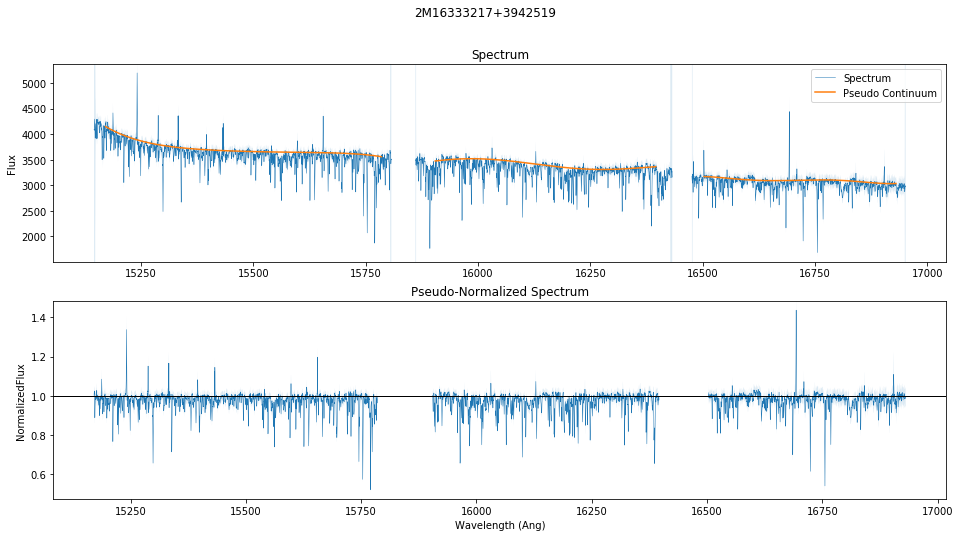

In [71]:
mysteryID, mysteryFlux, mysteryFluxErr = get_fits_flux('Mystery/mystery_spec_wiped_2M16333217+3942519.fits')
plot_pseudo_normalized(mysteryID, deg=5)

In [ ]:
mysteryFluxNorm, mysteryFluxErrNorm, _ = pseudo_normalize(wavelengths, mysteryFlux, mysteryFluxErr, deg=5)
mysteryHat = predict_features(mysteryFluxNorm, mysteryFluxErrNorm)
for name, hat in zip(mainCols, mysteryHat):
     print(f'{name} = {hat}')

In [ ]:
import pymc3 as pm

In [ ]:
with pm.Model() as model:
    labels = pm.Uniform('labels', lower=-10, upper=10, shape=(5,))
    polyFeatures = (labels**polynomializer.powers_).prod(axis=1, keepdims=True)
    fluxPred = pm.math.dot(polyFeatures.T, thetas)
    
    sigma = np.nan_to_num(np.sqrt(sigmas**2 + mysteryFluxErrNorm**2), nan=1e10)
    
    fluxObs = pm.Normal('fluxObs',
                        mu = fluxPred,
                        sigma = sigma,
                        observed = np.nan_to_num(mysteryFluxErrNorm, nan=0))
    

    
    trace = pm.sample(
        tune=500,
        draws=1000,
        chains=chains,
        cores=2
    )
    
    untransformedLabels = normalizer.inverse_transform(trace['labels'])
    traceDict = {
        col: untransformedLabels[:, i].reshape(chains, -1) for i, col in enumerate(mainCols)
    }